# Predicción de la tasa de churn

## Descripción del dataset

Nuestro dataset contiene información de clientes con las siguientes columnas:

- **CustomerID**: identificador único de cada cliente.  
- **Age**: edad del cliente. Puede influir en la propensión a abandonar según segmento.  
- **Gender**: género del cliente, útil para segmentación y patrones de comportamiento.  
- **Tenure**: tiempo que el cliente lleva usando el servicio; clientes nuevos suelen tener más riesgo de churn.  
- **Usage Frequency**: frecuencia de uso del servicio; un uso bajo puede indicar riesgo de abandono.  
- **Support Calls**: número de llamadas al soporte; clientes con problemas recurrentes pueden tener mayor riesgo.  
- **Payment Delay**: retrasos en pagos; indicador financiero de riesgo de churn.  
- **Subscription Type**: tipo de suscripción contratada; ciertos planes pueden tener mayor tasa de abandono.  
- **Contract Length**: duración del contrato; contratos cortos suelen tener mayor rotación.  
- **Total Spend**: gasto total del cliente; clientes de mayor gasto pueden ser más leales.  
- **Last Interaction**: tiempo desde la última interacción con el servicio; inactividad prolongada puede indicar riesgo de churn.  
- **Churn**: variable objetivo (1 si el cliente abandonó, 0 si permanece).

Estas columnas nos permiten generar **features relevantes** para predecir la probabilidad de churn.

## Enfoque de modelado

Dado que tenemos datos históricos etiquetados, aplicaremos **aprendizaje supervisado**.  

Inicialmente probaremos **varios modelos supervisados** para comparar su desempeño y seleccionar el más adecuado. Entre ellos:

- **Logistic Regression**  
- **Decision Tree**  
- **Random Forest**  
- **K-Nearest Neighbors (KNN)**  
- **Support Vector Machine (SVM)**  
- **Gradient Boosting / LightGBM**  

Este enfoque nos permitirá obtener **predicciones de churn confiables** y estimar la probabilidad de abandono de cada cliente.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
warnings.filterwarnings('ignore')


## 1. Importación de paquetes y dataset

In [25]:
df_test = pd.read_csv('../data/raw/customer_churn_dataset-testing-master.csv')
df_train = pd.read_csv('../data/raw/customer_churn_dataset-training-master.csv')

## 2.EDA y Visual EDA

In [26]:
df_train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [27]:
df_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  str    
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  str    
 8   Contract Length    440832 non-null  str    
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), str(3)
memory usage: 40.4 MB


In [28]:
df_train.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='str')

In [29]:
df_train.isnull().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [30]:
df_train.duplicated().sum()

np.int64(0)

### 2.1 Conocer las variables categóricas

In [31]:
print('Generos:\n', df_train['Gender'].unique())

Generos:
 <StringArray>
['Female', 'Male', nan]
Length: 3, dtype: str


In [32]:
print('Subscripciones:\n', df_train['Subscription Type'].unique())

Subscripciones:
 <StringArray>
['Standard', 'Basic', 'Premium', nan]
Length: 4, dtype: str


In [33]:
print('Longitud del contrato:\n', df_train['Contract Length'].unique())

Longitud del contrato:
 <StringArray>
['Annual', 'Monthly', 'Quarterly', nan]
Length: 4, dtype: str


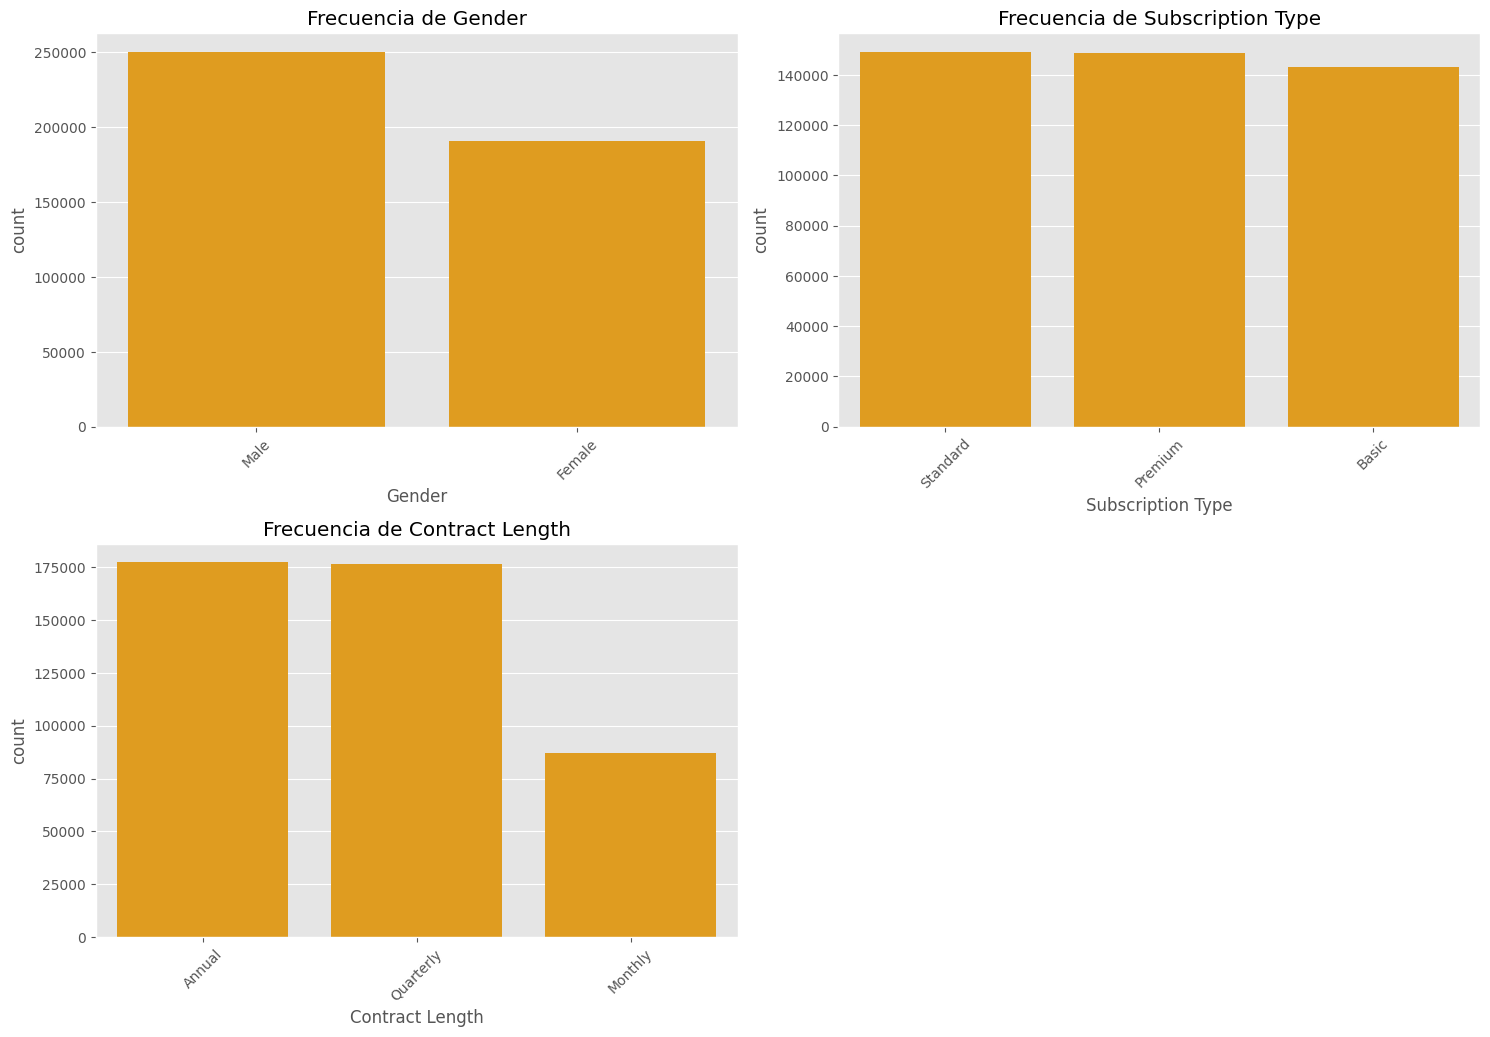

In [ ]:
cat_cols = ['Gender', 'Subscription Type', 'Contract Length']

plt.figure(figsize=(15, 30))

for i, col in enumerate(cat_cols):
    plt.subplot(6, 2, i + 1)
    # Ordenamos por conteo para verlo mejor
    sns.countplot(x=df_train[col], order=df_train[col].value_counts().index, color='orange')
    plt.title(f'Frecuencia de {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 2.2 Conocer las variables numericas

#### 2.2.1 CustomerID

In [34]:
# El campo CustomerID no aporta información relevante para el análisis, por lo que no se analizara más a fondo.

#### 2.2.2 Age

In [35]:
print('Min edad: ', df_train['Age'].max())
print('Max edad: ', df_train['Age'].min())
print('Valores Nulos: ', df_train['Age'].isnull().any())

Min edad:  65.0
Max edad:  18.0
Valores Nulos:  True


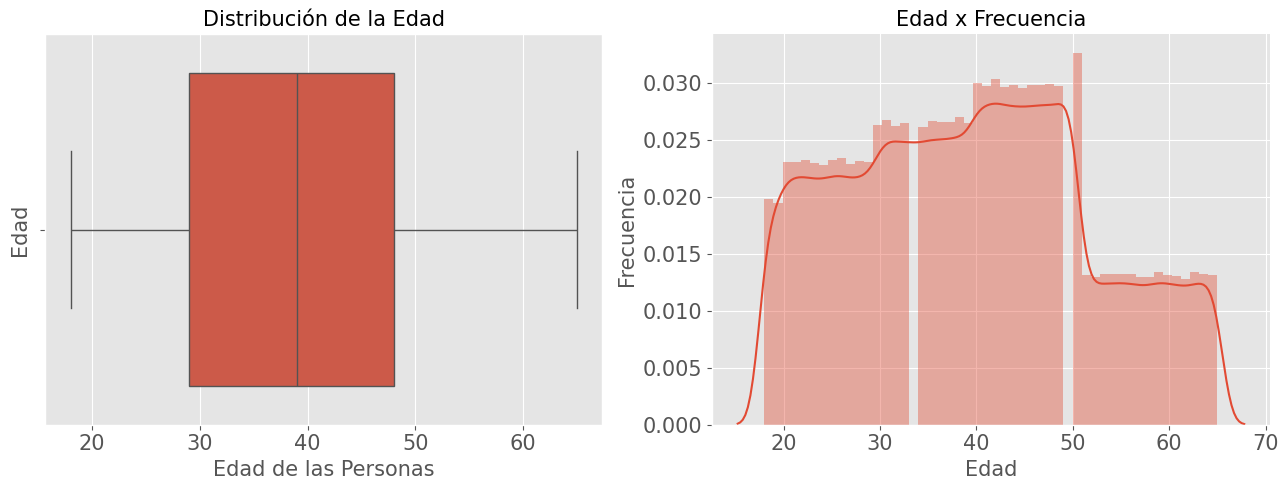

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))

# Gráfico 1: Diagrama de Caja (Boxplot)
sns.boxplot(x = 'Age', data = df_train, orient = 'v', ax = ax1)
ax1.set_xlabel('Edad de las Personas', fontsize=15)
ax1.set_ylabel('Edad', fontsize=15)
ax1.set_title('Distribución de la Edad', fontsize=15)
ax1.tick_params(labelsize=15)

# Gráfico 2: Histograma de distribución
sns.distplot(df_train['Age'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_xlabel('Edad', fontsize=15)
ax2.set_ylabel('Frecuencia', fontsize=15)
ax2.set_title('Edad x Frecuencia', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()



#### 2.2.3 Tenure

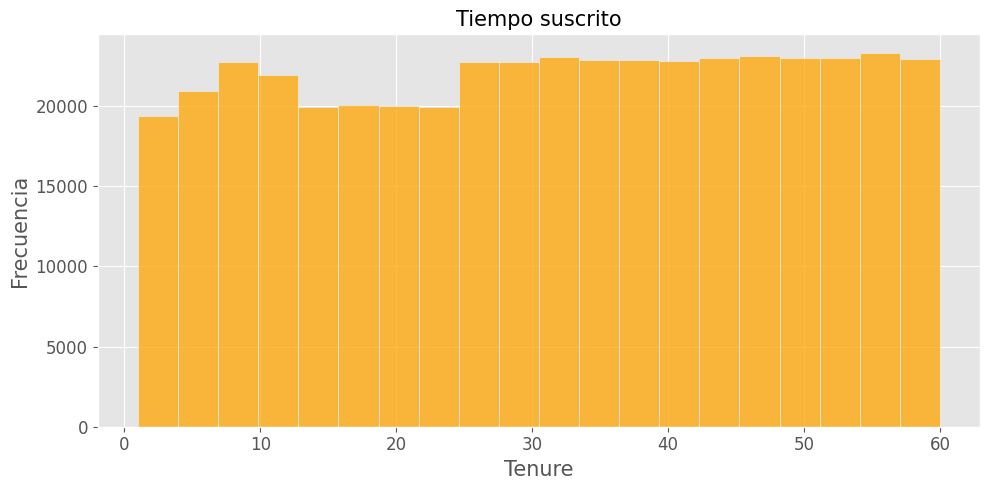

In [37]:
fig, ax2 = plt.subplots(figsize=(10,5))
sns.histplot(
    df_train['Tenure'],
    bins=20,          
    kde=False,        
    color='orange',   
    ax=ax2
)

ax2.set_xlabel('Tenure', fontsize=15)
ax2.set_ylabel('Frecuencia', fontsize=15)
ax2.set_title('Tiempo suscrito', fontsize=15)
ax2.tick_params(labelsize=12)

plt.tight_layout()  # ajuste final
plt.show()

#### 2.2.4 Usage Frequency

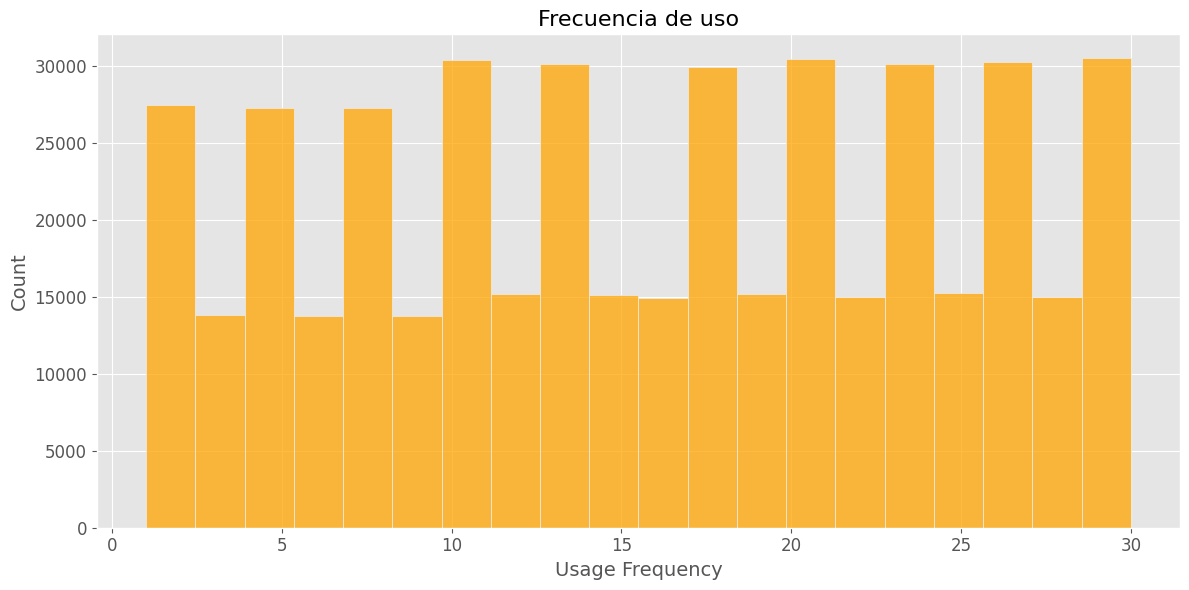

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(
    df_train['Usage Frequency'],
    bins=20,       # ajusta según rango de valores
    color='orange',
    kde=False,     # True si quieres curva de densidad
    ax=ax
)

ax.set_xlabel('Usage Frequency', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Frecuencia de uso', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()


#### 2.2.5 Support Calls

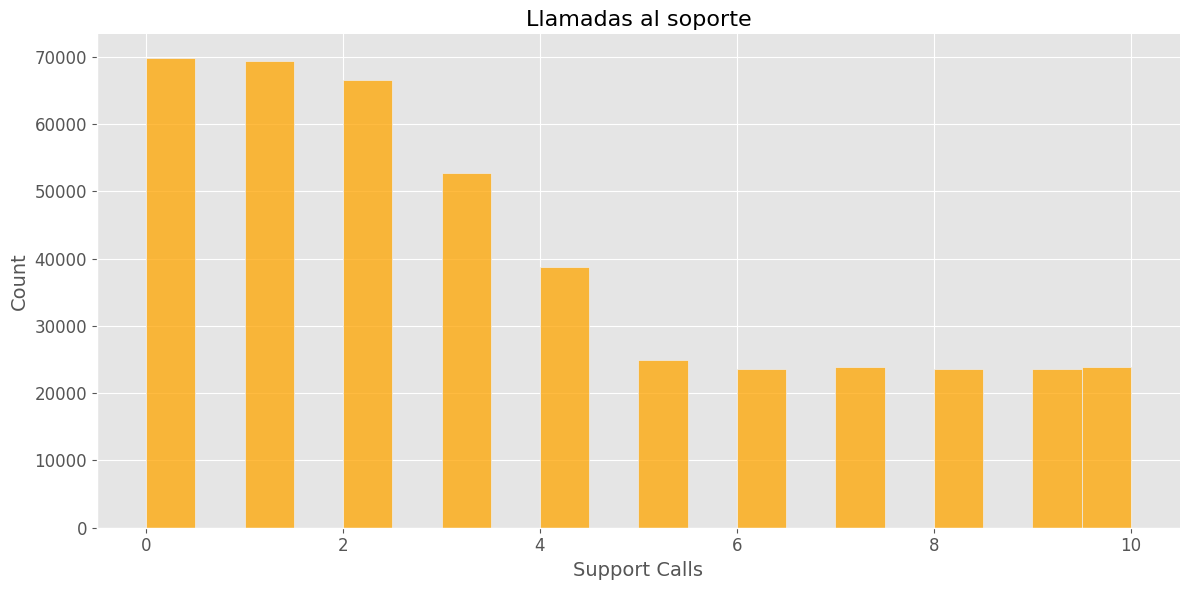

In [39]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(
    df_train['Support Calls'],
    bins=20,       # ajusta según rango de datos
    color='orange',
    kde=False,
    ax=ax
)

ax.set_xlabel('Support Calls', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Llamadas al soporte', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


#### 2.2.6 Payment Delay

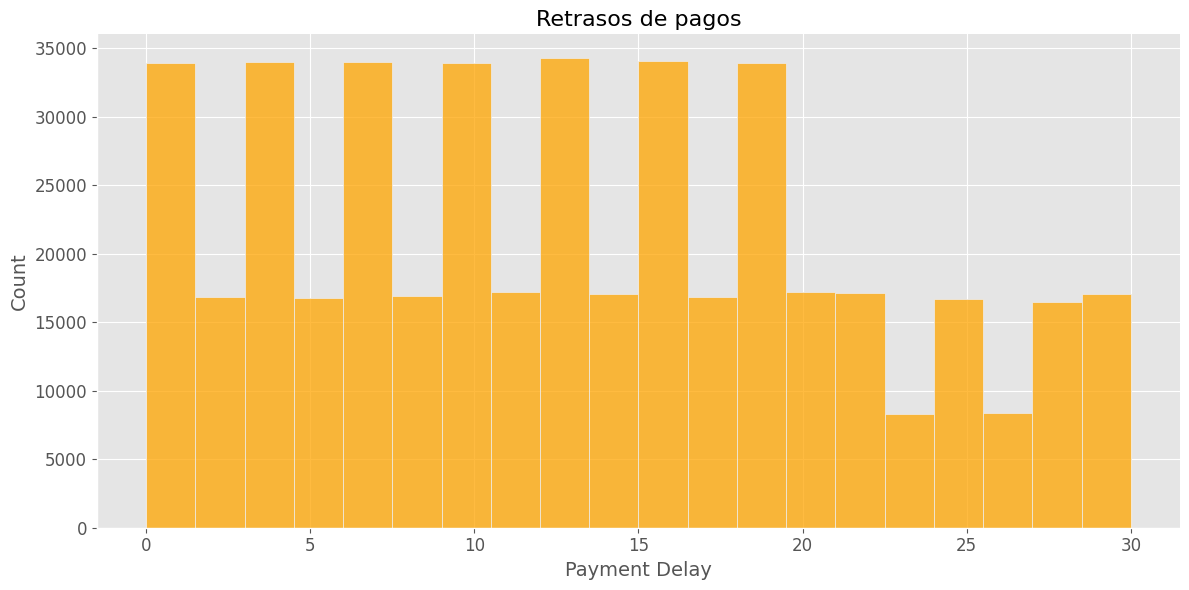

In [40]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(
    df_train['Payment Delay'],
    bins=20,       # ajusta según rango de datos
    color='orange',
    kde=False,
    ax=ax
)

ax.set_xlabel('Payment Delay', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Retrasos de pagos', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()

#### 2.2.7 Total Spend

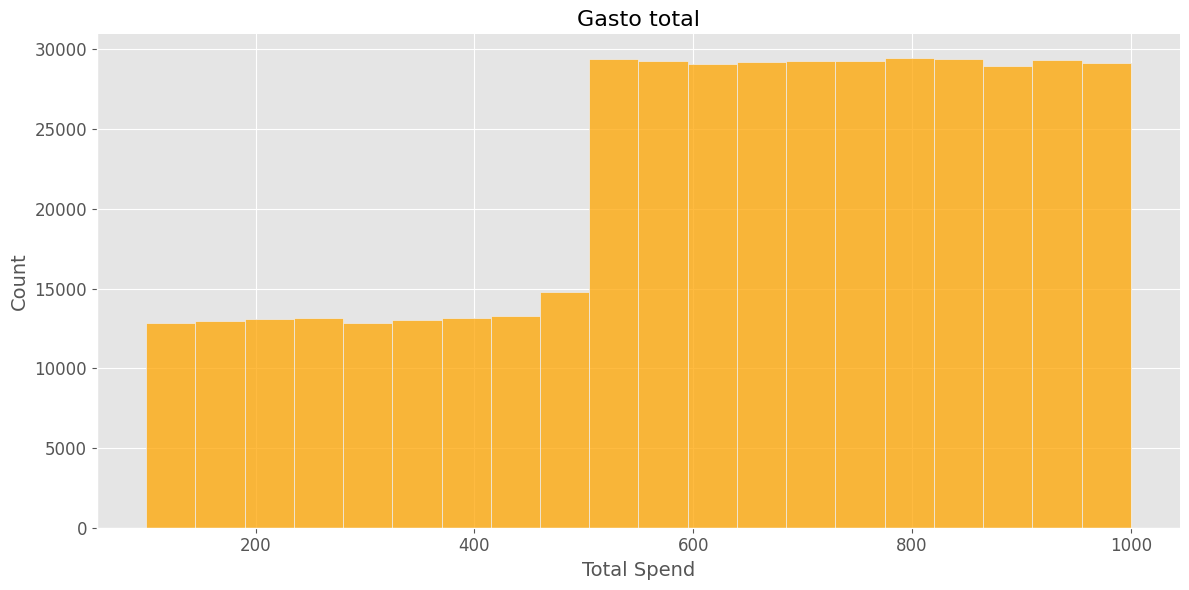

In [41]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(
    df_train['Total Spend'],
    bins=20,        # ajusta según el rango de gastos
    color='orange',
    kde=False,      # True si quieres curva de densidad
    ax=ax
)

ax.set_xlabel('Total Spend', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Gasto total', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


#### 2.2.8 Last Interaction

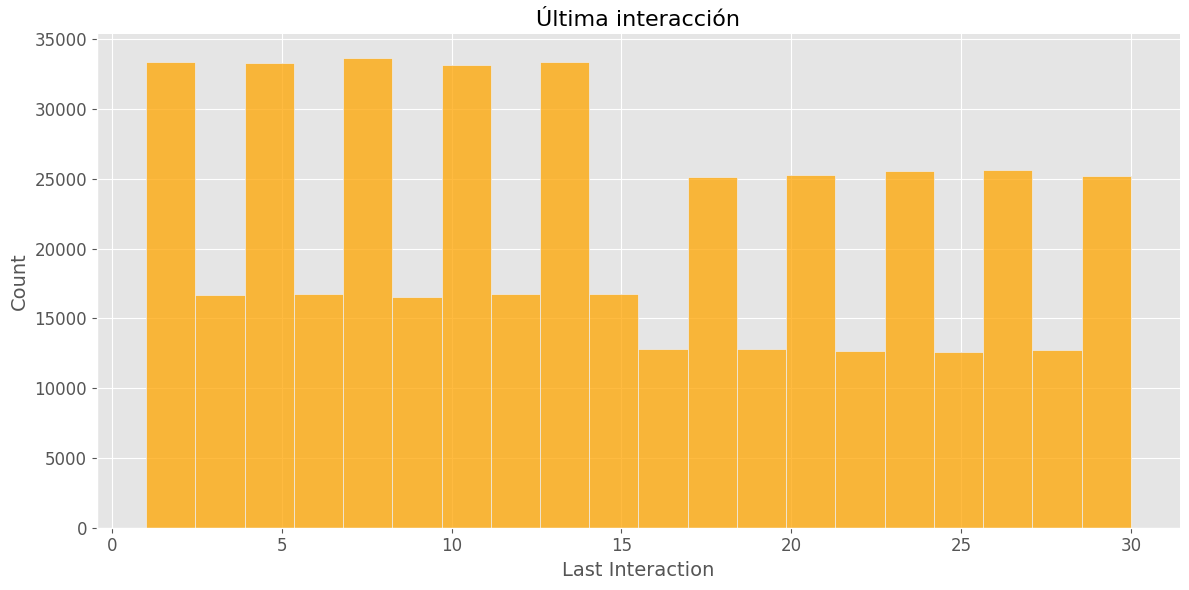

In [42]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(
    df_train['Last Interaction'],
    bins=20,        # ajusta según rango de datos
    color='orange',
    kde=False,
    ax=ax
)

ax.set_xlabel('Last Interaction', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Última interacción', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


#### 2.2.10 Total Churn

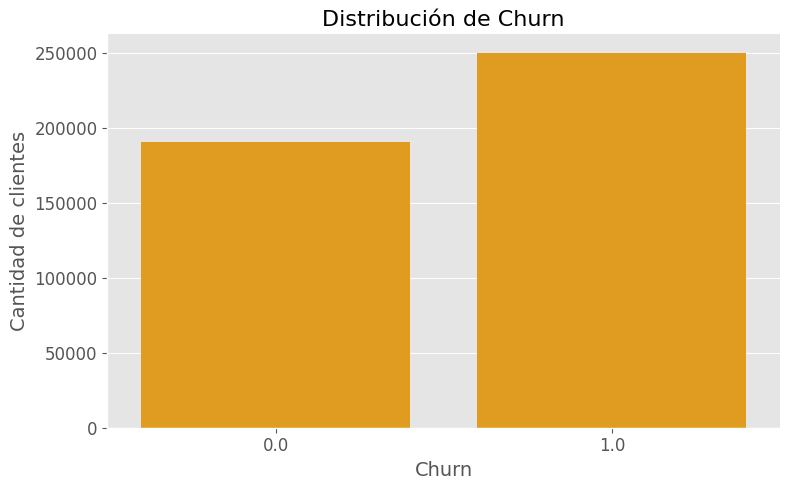

In [43]:
fig, ax = plt.subplots(figsize=(8,5))

# Countplot de Churn
sns.countplot(
    x='Churn',
    data=df_train,
    ax=ax,
    color='orange'
)

# Etiquetas y título
ax.set_xlabel('Churn', fontsize=14)
ax.set_ylabel('Cantidad de clientes', fontsize=14)
ax.set_title('Distribución de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()

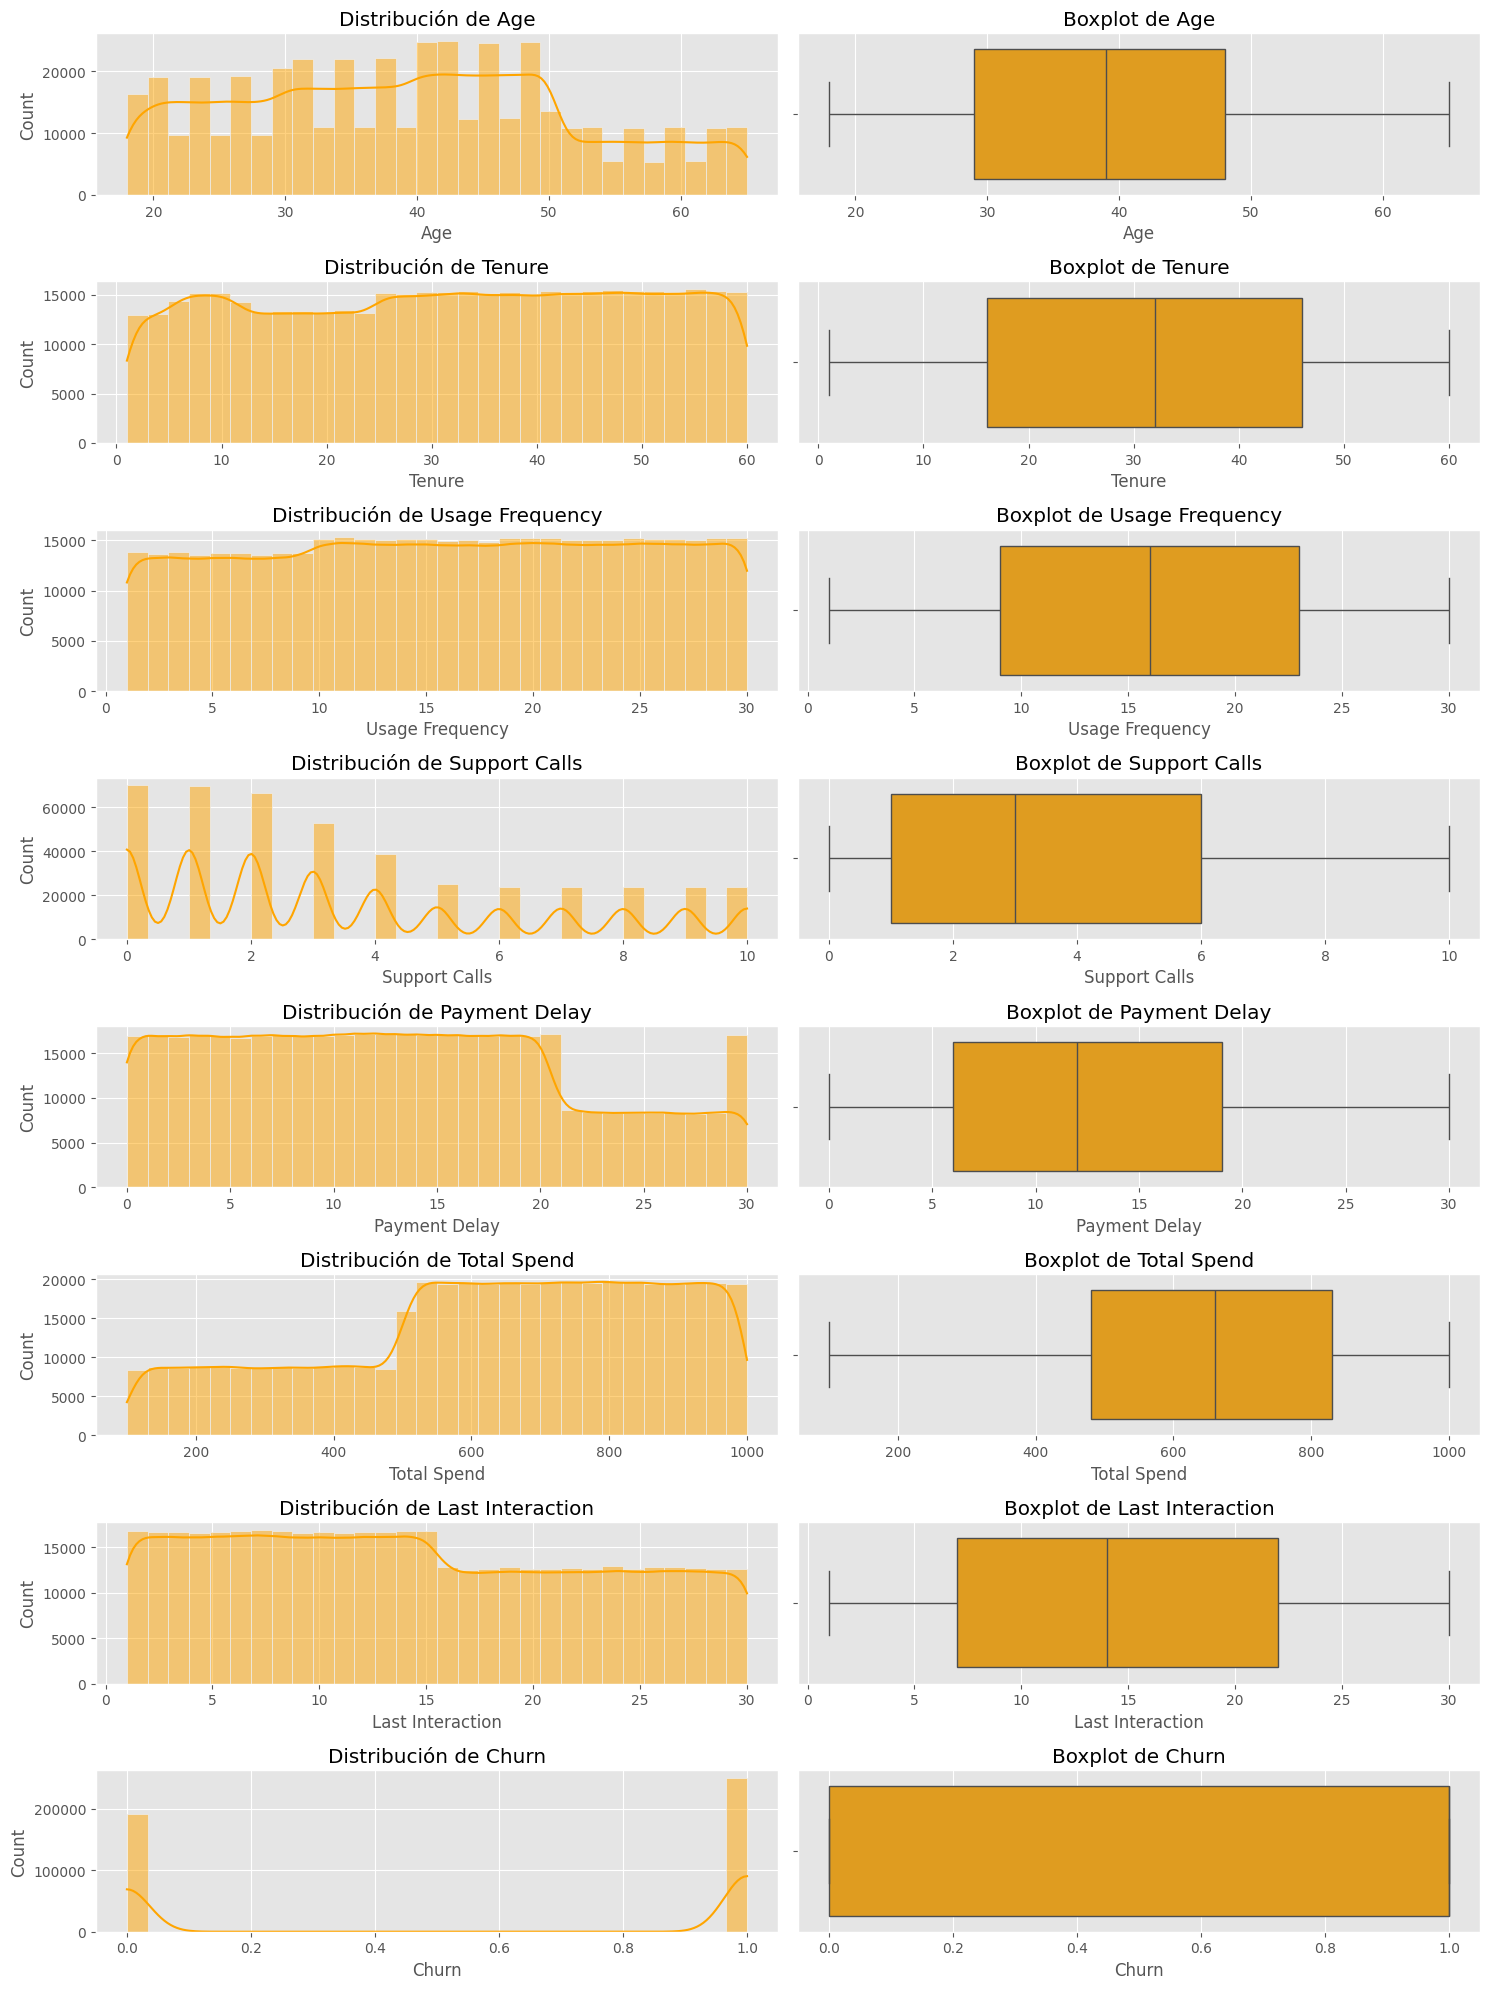

In [47]:
num_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 
            'Total Spend', 'Last Interaction', 'Churn']

# Configuración de gráficos
plt.figure(figsize=(15, 20))

for i, col in enumerate(num_cols):
    # Histograma
    plt.subplot(len(num_cols), 2, 2*i + 1)
    sns.histplot(df_train[col], kde=True, bins=30, color='orange')
    plt.title(f'Distribución de {col}')
    
    # Boxplot (para ver outliers)
    plt.subplot(len(num_cols), 2, 2*i + 2)
    sns.boxplot(x=df_train[col], color='orange')
    plt.title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()


### 2.2.11 Relaciones entre variables

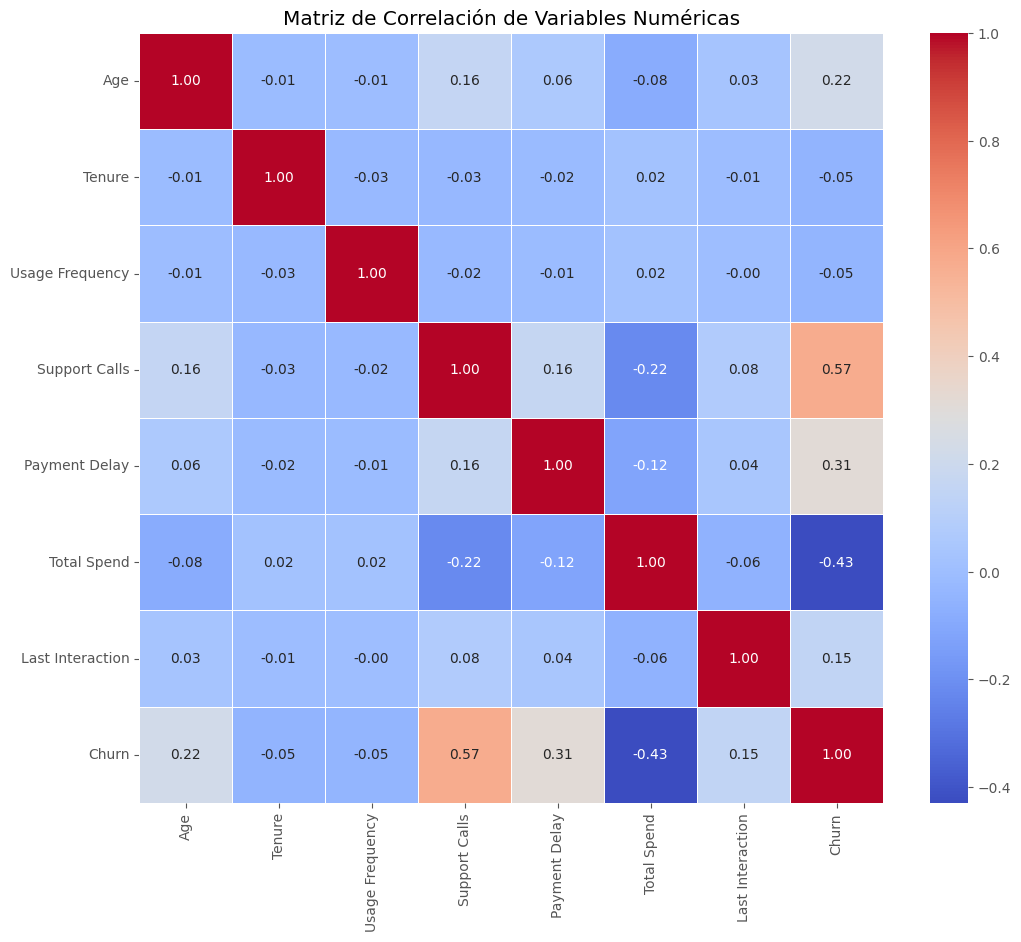

In [55]:
# Calculamos la correlación solo de las columnas numéricas
plt.figure(figsize=(12, 10))
corr_matrix = df_train[num_cols].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

Son variables muy "independientes", lo cual es bueno porque aportan información única que no se solapa con los datos económicos.

## 3. Preprocessing data

In [44]:
#Debido a los pocos valores nulos que hay en el dataset, se opta por eliminar las filas que los contienen.
df_train.dropna(inplace=True)

In [45]:
# Borrar CustomerID
df_train.drop(columns=['CustomerID'], inplace=True)